Loaded test data: 497 samples

BẮT ĐẦU ĐÁNH GIÁ TẤT CẢ MODELS

Tìm thấy 5 model(s):
  - Llama-3.1-8B_program.csv
  - mistral-7b-instruct-v0.3_program.csv
  - Qwen3-8B_program.csv
  - Phi4_finetuned_program.csv
  - Phi4_program.csv



Đánh giá Llama-3.1-8B:   0%|          | 0/497 [00:00<?, ?it/s]

Đánh giá Llama-3.1-8B: 100%|██████████| 497/497 [00:00<00:00, 955.07it/s] 


✓ Llama-3.1-8B: PA=0.20%, EA=0.40%


Đánh giá mistral-7b-instruct-v0.3: 100%|██████████| 497/497 [00:00<00:00, 1099.29it/s]


✓ mistral-7b-instruct-v0.3: PA=38.63%, EA=41.65%


Đánh giá Qwen3-8B: 100%|██████████| 497/497 [00:00<00:00, 1658.39it/s]


✓ Qwen3-8B: PA=59.56%, EA=64.19%


Đánh giá Phi4_finetuned: 100%|██████████| 497/497 [00:00<00:00, 979.26it/s] 


✓ Phi4_finetuned: PA=48.89%, EA=52.31%


Đánh giá Phi4: 100%|██████████| 497/497 [00:00<00:00, 1533.84it/s]


✓ Phi4: PA=53.92%, EA=57.55%

✓ Đã lưu bảng so sánh: evaluation_results/model_comparison_20260113_150751.csv
✓ Đã lưu biểu đồ: evaluation_results/model_comparison_20260113_150751.png

BẢNG SO SÁNH KẾT QUẢ CÁC MODELS
Model                PA Normalized        Execution Accuracy   Samples   
--------------------------------------------------------------------------------
Qwen3-8B             59.56%               64.19%               497       
Phi4                 53.92%               57.55%               497       
Phi4_finetuned       48.89%               52.31%               497       
mistral-7b-instruct-v0.3 38.63%               41.65%               497       
Llama-3.1-8B         0.20%                0.40%                497       

✓ Hoàn tất! Kết quả được lưu trong thư mục: evaluation_results/


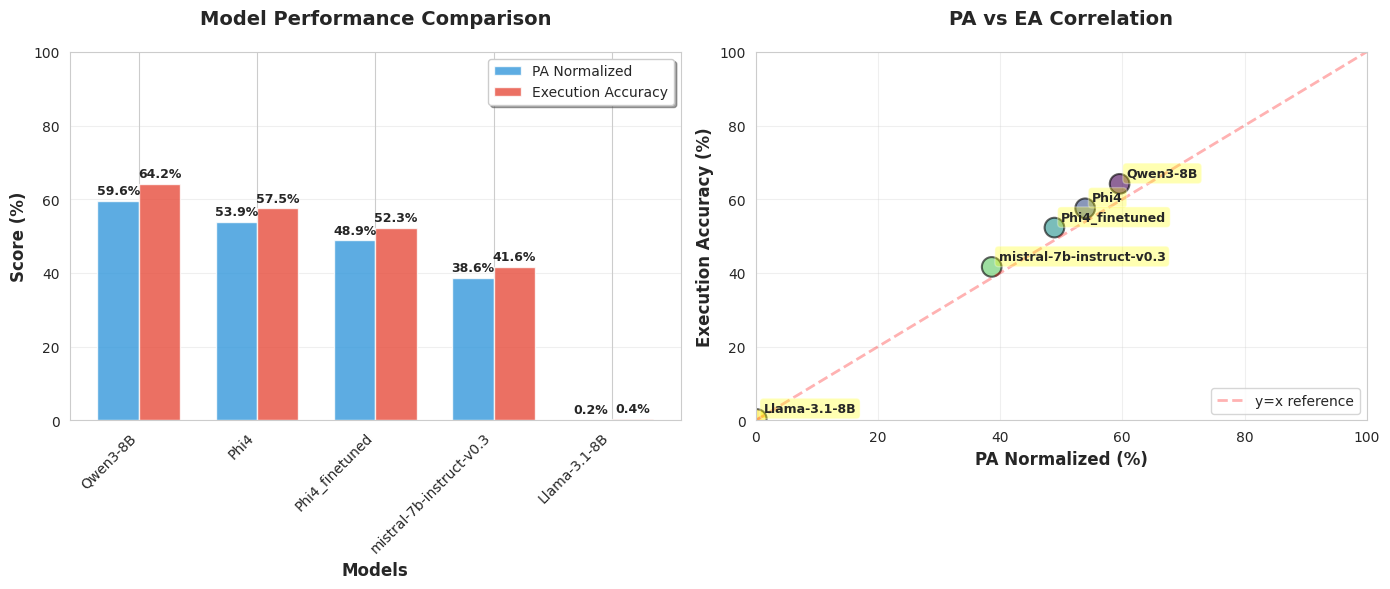

In [4]:
import json
import re
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
from tqdm import tqdm

# ==================== CẤU HÌNH ====================
DETAILS_DIR = "details"
TEST_JSON = "/workspaces/Numerical-Reasoning-QA-for-Vietnamese-Finance/data/test.json"
OUTPUT_DIR = "evaluation_results"

# Tạo thư mục output
Path(OUTPUT_DIR).mkdir(exist_ok=True)

# ==================== LOAD TEST DATA ====================
with open(TEST_JSON, "r", encoding="utf-8") as f:
    test_data = json.load(f)
test_dict = {item["id"]: item for item in test_data}

print(f"Loaded test data: {len(test_dict)} samples")

# ==================== HÀM CHUẨN HÓA & THỰC THI ====================
def normalize_program(prog: str) -> str:
    if not prog:
        return ""
    prog = re.sub(r'\s+', '', prog.lower())
    
    # Giao hoán add/multiply
    prog = re.sub(r'add\(([^,]+),([^)]+)\)', 
                  lambda m: 'add(' + ','.join(sorted([m.group(1), m.group(2)])) + ')', prog)
    prog = re.sub(r'multiply\(([^,]+),([^)]+)\)', 
                  lambda m: 'multiply(' + ','.join(sorted([m.group(1), m.group(2)])) + ')', prog)
    
    # Giữ nguyên subtract/divide
    prog = re.sub(r'subtract\(([^,]+),([^)]+)\)', r'subtract(\1,\2)', prog)
    prog = re.sub(r'divide\(([^,]+),([^)]+)\)', r'divide(\1,\2)', prog)
    
    # Chuẩn hóa table_
    prog = re.sub(r'table_(max|min|average|sum)\(([^,]+),none\)', r'table_\1(\2,None)', prog)
    
    # Renumber #0, #1,...
    refs = []
    def renumber(m):
        ref = m.group(0)
        if ref not in refs:
            refs.append(ref)
        return f"#{refs.index(ref)}"
    prog = re.sub(r'#\d+', renumber, prog)
    
    return prog


def execute_program(program: str, table: list) -> float:
    if not program:
        return None
    
    df = pd.DataFrame()
    if table and isinstance(table, list) and len(table) > 1:
        try:
            headers = table[0]
            rows = table[1:]
            if all(isinstance(r, list) for r in rows):
                df = pd.DataFrame(rows, columns=headers)
                for col in df.columns:
                    df[col] = pd.to_numeric(df[col], errors='coerce')
        except:
            pass
    
    results = []
    commands = re.split(r',(?![^()]*\))', program.strip())
    
    def resolve_arg(arg: str):
        arg = arg.strip()
        if arg.startswith('#'):
            try:
                idx = int(arg[1:])
                return results[idx] if 0 <= idx < len(results) else 0.0
            except:
                return 0.0
        try:
            return float(arg.replace(',', ''))
        except:
            return 0.0
    
    for cmd in commands:
        cmd = cmd.strip().lower()
        if not cmd:
            continue
        
        if cmd.startswith('add('):
            args = re.findall(r'add\(([^,]+),([^)]+)\)', cmd)
            if args:
                results.append(resolve_arg(args[0][0]) + resolve_arg(args[0][1]))
            continue
        
        if cmd.startswith('subtract('):
            args = re.findall(r'subtract\(([^,]+),([^)]+)\)', cmd)
            if args:
                results.append(resolve_arg(args[0][0]) - resolve_arg(args[0][1]))
            continue
        
        if cmd.startswith('multiply('):
            args = re.findall(r'multiply\(([^,]+),([^)]+)\)', cmd)
            if args:
                results.append(resolve_arg(args[0][0]) * resolve_arg(args[0][1]))
            continue
        
        if cmd.startswith('divide('):
            args = re.findall(r'divide\(([^,]+),([^)]+)\)', cmd)
            if args:
                a, b = resolve_arg(args[0][0]), resolve_arg(args[0][1])
                if abs(b) > 1e-10:
                    results.append(a / b)
            continue
        
        # Table functions
        for func in ['max', 'min', 'average', 'sum']:
            if cmd.startswith(f'table_{func}('):
                match = re.search(rf'table_{func}\((.+?)(?:,none|,None|\)|$)', cmd, re.I)
                if match:
                    raw_col = match.group(1).strip().strip('"').strip("'")
                    matched_col = None
                    for col in df.columns:
                        if raw_col.lower() in str(col).lower() or str(col).lower() in raw_col.lower():
                            matched_col = col
                            break
                    if matched_col is None and len(df.columns) > 0:
                        matched_col = df.columns[0]
                    
                    if matched_col:
                        try:
                            vals = pd.to_numeric(df[matched_col], errors='coerce').dropna()
                            if len(vals) > 0:
                                val = {
                                    'max': vals.max(),
                                    'min': vals.min(),
                                    'average': vals.mean(),
                                    'sum': vals.sum()
                                }[func]
                                results.append(float(val))
                        except:
                            pass
                break
    
    return results[-1] if results else None


def evaluate_model(csv_path: str, model_name: str):
    """Đánh giá 1 model"""
    df = pd.read_csv(csv_path)
    detailed_records = []
    
    for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Đánh giá {model_name}"):
        sample_id = row["id"]
        table = test_dict.get(sample_id, {}).get("table", [])
        
        gold_program_raw = row.get("gold_program", "")
        extracted_prog_raw = row.get("program_step2", "")
        
        gold_program = str(gold_program_raw) if pd.notna(gold_program_raw) else ""
        extracted_prog = str(extracted_prog_raw) if pd.notna(extracted_prog_raw) else ""
        
        gold_answer = row.get("gold_answer", "N/A")
        
        # Chuẩn hóa
        gold_norm = normalize_program(gold_program)
        norm_extracted = normalize_program(extracted_prog)
        
        # PA Normalized
        pa_norm = (norm_extracted == gold_norm)
        
        # EA
        try:
            gold_val = float(gold_answer)
        except:
            gold_val = None
        
        if pa_norm:
            exec_match = True
            exec_val_str = "N/A (PA correct)"
        else:
            exec_val = execute_program(extracted_prog.lower(), table)
            exec_val_str = f"{exec_val:.5f}".rstrip('0').rstrip('.') if exec_val is not None else "None"
            exec_match = abs(exec_val - gold_val) <= 0.001 if exec_val is not None and gold_val is not None else False
        
        detailed_records.append({
            "id": sample_id,
            "pa_normalized": 1 if pa_norm else 0,
            "execution_correct": 1 if exec_match else 0,
        })
    
    # Tính metrics
    n = len(detailed_records)
    pa_score = sum(r["pa_normalized"] for r in detailed_records) / n
    ea_score = sum(r["execution_correct"] for r in detailed_records) / n
    
    return {
        "model": model_name,
        "PA_Normalized": pa_score,
        "Execution_Accuracy": ea_score,
        "total_samples": n
    }


# ==================== ĐÁNH GIÁ TẤT CẢ MODELS ====================
print("\n" + "="*80)
print("BẮT ĐẦU ĐÁNH GIÁ TẤT CẢ MODELS")
print("="*80 + "\n")

# Tìm tất cả file *_program.csv
details_path = Path(DETAILS_DIR)
csv_files = list(details_path.glob("*_program.csv"))

if not csv_files:
    print(f"❌ Không tìm thấy file nào trong {DETAILS_DIR}/")
    exit(1)

print(f"Tìm thấy {len(csv_files)} model(s):")
for f in csv_files:
    print(f"  - {f.name}")
print()

# Đánh giá từng model
all_results = []
for csv_file in csv_files:
    model_name = csv_file.stem.replace("_program", "")  # Bỏ "_program"
    result = evaluate_model(str(csv_file), model_name)
    all_results.append(result)
    print(f"✓ {model_name}: PA={result['PA_Normalized']:.2%}, EA={result['Execution_Accuracy']:.2%}")

# ==================== TẠO BẢNG SO SÁNH ====================
results_df = pd.DataFrame(all_results)
results_df = results_df.sort_values("Execution_Accuracy", ascending=False)

# Lưu CSV
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
csv_output = f"{OUTPUT_DIR}/model_comparison_{timestamp}.csv"
results_df.to_csv(csv_output, index=False, encoding="utf-8")

print(f"\n✓ Đã lưu bảng so sánh: {csv_output}")

# ==================== TẠO BIỂU ĐỒ TRỰC QUAN ====================
# Set style
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = (12, 6)

# Tạo figure với 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Chuẩn bị data cho plot
models = results_df['model'].tolist()
pa_scores = (results_df['PA_Normalized'] * 100).tolist()
ea_scores = (results_df['Execution_Accuracy'] * 100).tolist()

x = range(len(models))

# Plot 1: Bar chart so sánh
width = 0.35
ax1.bar([i - width/2 for i in x], pa_scores, width, label='PA Normalized', color='#3498db', alpha=0.8)
ax1.bar([i + width/2 for i in x], ea_scores, width, label='Execution Accuracy', color='#e74c3c', alpha=0.8)

ax1.set_xlabel('Models', fontsize=12, fontweight='bold')
ax1.set_ylabel('Score (%)', fontsize=12, fontweight='bold')
ax1.set_title('Model Performance Comparison', fontsize=14, fontweight='bold', pad=20)
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=45, ha='right')
ax1.legend(loc='upper right', frameon=True, shadow=True)
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim(0, 100)

# Thêm giá trị trên mỗi cột
for i, (pa, ea) in enumerate(zip(pa_scores, ea_scores)):
    ax1.text(i - width/2, pa + 1, f'{pa:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')
    ax1.text(i + width/2, ea + 1, f'{ea:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Plot 2: Scatter plot PA vs EA
ax2.scatter(pa_scores, ea_scores, s=200, alpha=0.6, c=range(len(models)), cmap='viridis', edgecolors='black', linewidth=1.5)

for i, model in enumerate(models):
    ax2.annotate(model, (pa_scores[i], ea_scores[i]), 
                xytext=(5, 5), textcoords='offset points', 
                fontsize=9, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3))

ax2.set_xlabel('PA Normalized (%)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Execution Accuracy (%)', fontsize=12, fontweight='bold')
ax2.set_title('PA vs EA Correlation', fontsize=14, fontweight='bold', pad=20)
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 100)
ax2.set_ylim(0, 100)

# Thêm đường y=x reference
ax2.plot([0, 100], [0, 100], 'r--', alpha=0.3, linewidth=2, label='y=x reference')
ax2.legend(loc='lower right')

plt.tight_layout()

# Lưu hình
image_output = f"{OUTPUT_DIR}/model_comparison_{timestamp}.png"
plt.savefig(image_output, dpi=300, bbox_inches='tight')
print(f"✓ Đã lưu biểu đồ: {image_output}")

# ==================== IN BẢNG KẾT QUẢ RA CONSOLE ====================
print("\n" + "="*80)
print("BẢNG SO SÁNH KẾT QUẢ CÁC MODELS")
print("="*80)
print(f"{'Model':<20} {'PA Normalized':<20} {'Execution Accuracy':<20} {'Samples':<10}")
print("-"*80)
for _, row in results_df.iterrows():
    print(f"{row['model']:<20} {row['PA_Normalized']:<20.2%} {row['Execution_Accuracy']:<20.2%} {row['total_samples']:<10}")
print("="*80)

print(f"\n✓ Hoàn tất! Kết quả được lưu trong thư mục: {OUTPUT_DIR}/")